## Data Exploration

In [48]:
# https://hc18.grand-challenge.org/
# https://zenodo.org/record/1327317#.YFcz5Z0zZPY
# data/hc18

In [49]:
%ls ../../../data/hc18

test_set/                training_set/                       training_set.zip
test_set_pixel_size.csv  training_set_pixel_size_and_HC.csv
test_set.zip             training_set_Thumbs.db


In [50]:
import os
path2train="../../../data/hc18/training_set/"

imgsList=[pp for pp in os.listdir(path2train) if "Annotation" not in pp]
anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]
print("number of images:", len(imgsList))
print("number of annotations:", len(anntsList))

number of images: 999
number of annotations: 999


In [51]:
import numpy as np
np.random.seed(2019)
rndImgs=np.random.choice(imgsList,4)
rndImgs

array(['166_2HC.png', '434_HC.png', '244_HC.png', '826_3HC.png'],
      dtype='<U11')

In [52]:
# https://scikit-image.org/docs/dev/install.html

In [53]:
# https://anaconda.org/anaconda/scikit-image

In [54]:
#import matplotlib

In [55]:
import albumentations

In [56]:
import matplotlib
matplotlib.__version__

'3.3.4'

In [57]:
import matplotlib.pyplot as plt

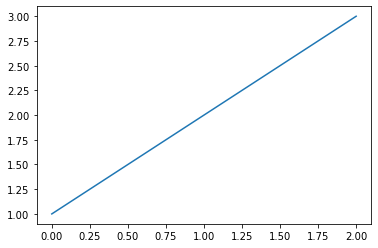

In [58]:
plt.plot([1,2,3])

In [59]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch

def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)
    

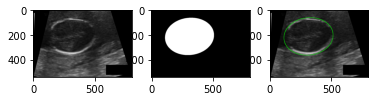

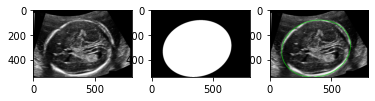

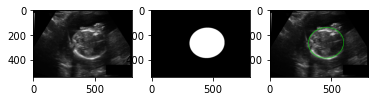

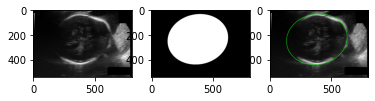

In [60]:

for fn in rndImgs:
    path2img = os.path.join(path2train, fn)
    path2annt= path2img.replace(".png", "_Annotation.png")
    img = Image.open(path2img)
    annt_edges = Image.open(path2annt)
    mask = ndi.binary_fill_holes(annt_edges)        

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask, cmap="gray")

    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask)
    

(-0.5, 799.5, 539.5, -0.5)

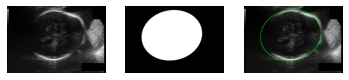

In [61]:
plt.figure()
plt.subplot(1, 3, 1) 
plt.imshow(img, cmap="gray")
plt.axis('off')

plt.subplot(1, 3, 2) 
plt.imshow(mask, cmap="gray")
plt.axis('off')    

plt.subplot(1, 3, 3) 
show_img_mask(img, mask)
plt.axis('off')


In [62]:
# https://anaconda.org/conda-forge/albumentations
#%conda install -c conda-forge albumentations

In [63]:
import albumentations

In [64]:
from albumentations import (
    HorizontalFlip,
    VerticalFlip,    
    Compose,
    Resize,
)

h,w=128,192
transform_train = Compose([ Resize(h,w), 
                HorizontalFlip(p=0.5), 
                VerticalFlip(p=0.5), 
              ])


transform_val = Resize(h,w)


## Creating Custom Dataset

In [65]:
from torch.utils.data import Dataset
from PIL import Image

In [66]:
from torchvision.transforms.functional import to_tensor, to_pil_image

class fetal_dataset(Dataset):
    def __init__(self, path2data, transform=None):      

        imgsList=[pp for pp in os.listdir(path2data) if "Annotation" not in pp]
        anntsList=[pp for pp in os.listdir(path2train) if "Annotation" in pp]

        self.path2imgs = [os.path.join(path2data, fn) for fn in imgsList] 
        self.path2annts= [p2i.replace(".png", "_Annotation.png") for p2i in self.path2imgs]

        self.transform = transform
    
    def __len__(self):
        return len(self.path2imgs)
      
    def __getitem__(self, idx):
        path2img = self.path2imgs[idx]
        image = Image.open(path2img)

        path2annt = self.path2annts[idx]
        annt_edges = Image.open(path2annt)
        mask = ndi.binary_fill_holes(annt_edges)        
        
        image= np.array(image)
        mask=mask.astype("uint8")        

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']            

        image= to_tensor(image)            
        mask=255*to_tensor(mask)            
        return image, mask


In [67]:
fetal_ds1=fetal_dataset(path2train, transform=transform_train)
fetal_ds2=fetal_dataset(path2train, transform=transform_val)
print(len(fetal_ds1))
print(len(fetal_ds2))

999
999


In [68]:
img,mask=fetal_ds1[0]
print(img.shape, img.type(),torch.max(img))
print(mask.shape, mask.type(),torch.max(mask))

torch.Size([1, 128, 192]) torch.FloatTensor tensor(0.9529)
torch.Size([1, 128, 192]) torch.FloatTensor tensor(1.)


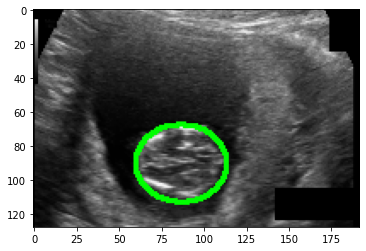

In [69]:
show_img_mask(img, mask)

### Split data into train validation

In [70]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=range(len(fetal_ds1))

for train_index, val_index in sss.split(indices):
    print(len(train_index))
    print("-"*10)
    print(len(val_index))

799
----------
200


In [71]:
from torch.utils.data import Subset

train_ds=Subset(fetal_ds1,train_index)
print(len(train_ds))

val_ds=Subset(fetal_ds2,val_index)
print(len(val_ds))

799
200


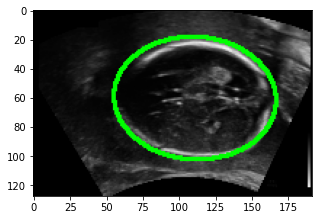

In [72]:
plt.figure(figsize=(5,5))
for img,mask in train_ds:
    show_img_mask(img,mask)
    break

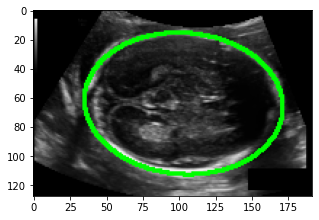

In [73]:
plt.figure(figsize=(5,5))
for img,mask in val_ds:
    show_img_mask(img,mask)
    break

### Creating DataLoader

In [74]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False) 

In [75]:
for img_b, mask_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([8, 1, 128, 192]) torch.float32
torch.Size([8, 1, 128, 192]) torch.float32


In [76]:
for img_b, mask_b in val_dl:
    print(img_b.shape,img_b.dtype)
    print(mask_b.shape, mask_b.dtype)
    break

torch.Size([16, 1, 128, 192]) torch.float32
torch.Size([16, 1, 128, 192]) torch.float32


In [77]:
torch.max(img_b)

tensor(0.9961)

## Creating the Model

In [78]:
import torch.nn as nn
import torch.nn.functional as F

In [79]:

class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_outputs=params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)    
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))

        x = self.conv_out(x)
        
        return x 

In [80]:
params_model={
        "input_shape": (1,h,w),
        "initial_filters": 16, 
        "num_outputs": 1,
            }

model = SegNet(params_model)

In [81]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [82]:
print(model)

SegNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (conv_up1): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_up4): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_out): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [83]:
#from torchsummary import summary
#summary(model, input_size=(1, h, w))

## Define Loss Function

In [84]:
def dice_loss(pred, target, smooth = 1e-5):

    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    
    return loss.sum(), dice.sum()

In [85]:

import torch.nn.functional as F

def loss_func(pred, target):
    bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
    
    pred= torch.sigmoid(pred)
    dlv, _ = dice_loss(pred, target)
    
    loss = bce  + dlv

    return loss

In [86]:
for img_v,mask_v in val_dl:
    mask_v= mask_v[8:]
    break

for img_t,mask_t in train_dl:
    break
    


print(dice_loss(mask_v,mask_v))
loss_func(mask_v,torch.zeros_like(mask_v))


(tensor(0.), tensor(8.))


tensor(170598.4844)

In [87]:
import torchvision

def metrics_batch(pred, target):
    pred= torch.sigmoid(pred)
    _, metric=dice_loss(pred, target)
    
    return metric

In [88]:
def loss_batch(loss_func, output, target, opt=None):   
    loss = loss_func(output, target)
    
    with torch.no_grad():
        pred= torch.sigmoid(output)
        _, metric_b=dice_loss(pred, target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

## Optimizer

In [89]:
from torch import optim
opt = optim.Adam(model.parameters(), lr=3e-4)

In [90]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [91]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


## Training the Model

In [92]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        
        output=model(xb)
        loss_b, metric_b=loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
        
        if metric_b is not None:
            running_metric+=metric_b

        if sanity_check is True:
            break
    
    loss=running_loss/float(len_data)
    
    metric=running_metric/float(len_data)
    
    return loss, metric

In [93]:
import copy
def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    loss_history={
        "train": [],
        "val": []}
    
    metric_history={
        "train": [],
        "val": []}    
    
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')    
    
    for epoch in range(num_epochs):
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))   

        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
       
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)   
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
            
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 
            
        print("train loss: %.6f, dice: %.2f" %(train_loss,100*train_metric))
        print("val loss: %.6f, dice: %.2f" %(val_loss,100*val_metric))
        print("-"*10) 
        

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history        


In [94]:
# mv KKH/data/hc18/training_set/Thumbs.db KKH/data/hc18/training_set_Thumbs.db

In [99]:
opt = optim.Adam(model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

path2models= "./models/"
if not os.path.exists(path2models):
        os.mkdir(path2models)

params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2models+"weights.pt",
}

In [100]:
model,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/9, current lr=0.0003
Copied best model weights!
train loss: 1397.466555, dice: 93.17
val loss: 1778.434868, dice: 91.72
----------
Epoch 1/9, current lr=0.0003
Copied best model weights!
train loss: 1332.362114, dice: 93.39
val loss: 1760.868496, dice: 92.88
----------
Epoch 2/9, current lr=0.0003
train loss: 1313.007783, dice: 93.54
val loss: 1913.601963, dice: 92.70
----------
Epoch 3/9, current lr=0.0003
train loss: 1262.211263, dice: 93.77
val loss: 1827.624038, dice: 93.08
----------
Epoch 4/9, current lr=0.0003
train loss: 1279.558225, dice: 93.76
val loss: 2024.875093, dice: 92.03
----------
Epoch 5/9, current lr=0.0003
train loss: 1316.443006, dice: 93.52
val loss: 1872.142510, dice: 93.25
----------
Epoch 6/9, current lr=0.0003
train loss: 1231.433893, dice: 93.98
val loss: 1791.655986, dice: 93.29
----------
Epoch 7/9, current lr=0.0003
Copied best model weights!
train loss: 1173.236939, dice: 94.12
val loss: 1753.621997, dice: 93.58
----------
Epoch 8/9, current lr=0

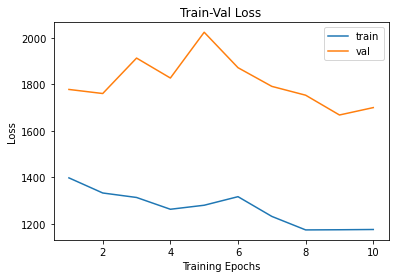

In [101]:
num_epochs=params_train["num_epochs"]

plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

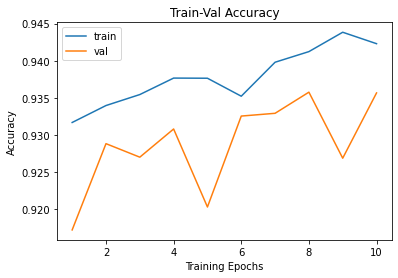

In [102]:
# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()